**Imports**

In [68]:
import yfinance as yf
from datetime import datetime
import pandas as pd
from typing import Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import math

import numpy as np
from dataclasses import dataclass
from typing import Iterable, Dict, Tuple, Optional
from scipy.interpolate import Akima1DInterpolator, PchipInterpolator
from scipy.optimize import curve_fit



**Define price fetcher**

In [69]:
def get_spot_price(ticker):
    """
    Fetches the current spot price for a stock ticker. Falls back to the most recent
    close if a live price is not available.

    Parameters
    ----------
    ticker : str
        Stock ticker symbol (e.g., 'AAPL').

    Returns
    -------
    float or None
        Spot price (live if available, else last close). Returns None if unavailable.
    """

    try:
        tk = yf.Ticker(ticker)
        
        # Attempt to fetch live price
        live_price = tk.fast_info.get("last_price", None)
        if live_price and live_price > 0:
            return live_price

        # Fallback: most recent close
        hist = tk.history(period="1d")
        if not hist.empty:
            fallback_price = hist["Close"].iloc[-1]
            print(f"[{ticker}] Live price unavailable — using last close: {fallback_price:.2f}")
            return fallback_price

        print(f"[{ticker}] No live or historical data available.")
        return None

    except Exception as e:
        print(f"[{ticker}] Spot price fetch failed: {e}")
        return None

**Define Option Chain Fetcher**

In [70]:
def get_option_chains_all(ticker: str,
                                  max_workers: int = 8) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fetches option chains (calls and puts) for every available expiry of a given ticker,
    performing API requests in parallel to reduce total fetch time.

    Parameters
    ----------
    ticker : str
        Stock ticker symbol (e.g., 'AAPL').
    max_workers : int, optional
        Maximum number of threads to use for concurrent fetching (default is 8).

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        - calls_df: DataFrame containing all calls across expiries, with added columns:
            * 'option_type' = 'call'
            * 'expiration'  = expiry date string 'YYYY-MM-DD'
            * 'TTM'         = time to maturity in years
        - puts_df: DataFrame containing all puts with the same added columns.
    """
    stock = yf.Ticker(ticker)
    expiries = stock.options  # list of expiry date strings
    today = datetime.now().date()

    calls_accum = []
    puts_accum  = []

    def fetch_chain(expiry: str):
        """Fetch calls/puts for a single expiry and return (expiry, calls_df, puts_df)."""
        try:
            chain = stock.option_chain(expiry)
            calls = chain.calls.copy()
            puts  = chain.puts.copy()
        except Exception as e:
            # Return None on error so we can skip later
            return expiry, None, None

        # Tag each row with type and expiration
        calls['option_type']  = 'call'
        puts ['option_type']  = 'put'
        calls['expiration']   = expiry
        puts ['expiration']   = expiry

        # Compute time-to-maturity once
        exp_date = datetime.strptime(expiry, "%Y-%m-%d").date()
        ttm = max((exp_date - today).days / 365.0, 0.0)
        calls['TTM'] = ttm
        puts ['TTM'] = ttm

        return expiry, calls, puts

    # Fetch in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(fetch_chain, exp) for exp in expiries]
        for future in as_completed(futures):
            expiry, calls_df, puts_df = future.result()
            if calls_df is not None and not calls_df.empty:
                calls_accum.append(calls_df)
            if puts_df  is not None and not puts_df.empty:
                puts_accum.append(puts_df)

    # Concatenate results
    all_calls = pd.concat(calls_accum, ignore_index=True) if calls_accum else pd.DataFrame()
    all_puts  = pd.concat(puts_accum,  ignore_index=True) if puts_accum  else pd.DataFrame()

    # Fetch dividend yield for the company
    dividendYield = stock.info.get("dividendYield")/100 # percentages on decimal basis
    all_calls["dividendYield"] = dividendYield
    all_puts["dividendYield"] = dividendYield

    all_calls["ticker"] = ticker
    all_puts["ticker"] = ticker

    spot_price = get_spot_price(ticker)
    all_calls["spot_price"] = spot_price
    all_puts["spot_price"] = spot_price

    return all_calls, all_puts


Get option chain and dividend yield

In [71]:
calls, puts = get_option_chains_all("AAPL")

[AAPL] Live price unavailable — using last close: 267.45


In [72]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,option_type,expiration,TTM,dividendYield,ticker,spot_price
0,AAPL251205C00165000,2025-10-31 13:30:12+00:00,165.0,111.70,102.35,104.10,0.000000,0.000000,1.0,1,0.885255,True,REGULAR,USD,call,2025-12-05,0.084932,0.0038,AAPL,267.450012
1,AAPL251205C00170000,2025-10-31 14:11:10+00:00,170.0,100.24,96.80,98.90,0.000000,0.000000,1.0,1,0.748049,True,REGULAR,USD,call,2025-12-05,0.084932,0.0038,AAPL,267.450012
2,AAPL251205C00185000,2025-10-31 13:30:12+00:00,185.0,92.00,82.45,84.20,0.000000,0.000000,10.0,10,0.718753,True,REGULAR,USD,call,2025-12-05,0.084932,0.0038,AAPL,267.450012
3,AAPL251205C00190000,2025-11-03 17:00:18+00:00,190.0,78.25,77.55,79.15,-3.660004,-4.468323,10.0,32,0.678714,True,REGULAR,USD,call,2025-12-05,0.084932,0.0038,AAPL,267.450012
4,AAPL251205C00200000,2025-10-31 17:27:12+00:00,200.0,71.02,67.65,69.15,0.000000,0.000000,1.0,3,0.599613,True,REGULAR,USD,call,2025-12-05,0.084932,0.0038,AAPL,267.450012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,AAPL280121C00490000,2025-10-31 19:49:20+00:00,490.0,4.90,4.45,4.70,0.000000,0.000000,1.0,25,0.277702,False,REGULAR,USD,call,2028-01-21,2.213699,0.0038,AAPL,267.450012
1222,AAPL280121C00500000,2025-11-03 17:02:25+00:00,500.0,4.10,4.00,4.25,-0.400000,-8.888890,7.0,277,0.277717,False,REGULAR,USD,call,2028-01-21,2.213699,0.0038,AAPL,267.450012
1223,AAPL280121C00510000,2025-10-31 19:55:00+00:00,510.0,3.90,3.60,3.85,0.000000,0.000000,30.0,30,0.277839,False,REGULAR,USD,call,2028-01-21,2.213699,0.0038,AAPL,267.450012
1224,AAPL280121C00520000,2025-11-03 17:01:12+00:00,520.0,3.39,3.25,3.45,0.090000,2.727277,7.0,4,0.277290,False,REGULAR,USD,call,2028-01-21,2.213699,0.0038,AAPL,267.450012


In [73]:
puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,option_type,expiration,TTM,dividendYield,ticker,spot_price
0,AAPL251205P00140000,2025-10-27 18:44:31+00:00,140.0,0.03,0.00,0.04,0.00,0.000000,NaN,1,0.734378,False,REGULAR,USD,put,2025-12-05,0.084932,0.0038,AAPL,267.450012
1,AAPL251205P00160000,2025-10-31 17:20:20+00:00,160.0,0.01,0.00,0.05,0.00,0.000000,1.0,1,0.601566,False,REGULAR,USD,put,2025-12-05,0.084932,0.0038,AAPL,267.450012
2,AAPL251205P00165000,2025-10-31 18:46:33+00:00,165.0,0.03,0.00,0.05,0.00,0.000000,5.0,5,0.570317,False,REGULAR,USD,put,2025-12-05,0.084932,0.0038,AAPL,267.450012
3,AAPL251205P00175000,2025-11-03 14:33:06+00:00,175.0,0.04,0.01,0.07,-0.01,-20.000002,2.0,2,0.527348,False,REGULAR,USD,put,2025-12-05,0.084932,0.0038,AAPL,267.450012
4,AAPL251205P00180000,2025-10-30 19:38:59+00:00,180.0,0.06,0.02,0.08,0.00,0.000000,NaN,1,0.507817,False,REGULAR,USD,put,2025-12-05,0.084932,0.0038,AAPL,267.450012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,AAPL280121P00380000,2025-10-31 18:34:12+00:00,380.0,108.95,112.80,113.25,0.00,0.000000,5.0,8,0.128427,True,REGULAR,USD,put,2028-01-21,2.213699,0.0038,AAPL,267.450012
1053,AAPL280121P00390000,2025-10-31 18:34:34+00:00,390.0,118.33,122.35,122.95,0.00,0.000000,18.0,21,0.125802,True,REGULAR,USD,put,2028-01-21,2.213699,0.0038,AAPL,267.450012
1054,AAPL280121P00400000,2025-10-30 16:43:32+00:00,400.0,128.50,132.40,132.95,0.00,0.000000,NaN,0,0.132760,True,REGULAR,USD,put,2028-01-21,2.213699,0.0038,AAPL,267.450012
1055,AAPL280121P00450000,2025-10-29 13:35:18+00:00,450.0,180.74,180.00,185.00,0.00,0.000000,NaN,0,0.217568,True,REGULAR,USD,put,2028-01-21,2.213699,0.0038,AAPL,267.450012


In [74]:
calls.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,TTM,dividendYield,spot_price
count,1226.000000,1226.000000,1226.000000,1226.000000,1226.000000,1226.000000,1184.000000,1226.000000,1226.000000,1226.000000,1.226000e+03,1226.000000
mean,241.272431,65.756060,65.516215,66.522822,-0.957496,-8.707712,241.739865,2683.544046,0.516594,0.680744,3.800000e-03,267.450012
std,115.648359,68.776507,69.831519,70.900223,1.967685,17.546277,1492.101588,6928.065037,0.442930,0.695275,2.429604e-17,0.000000
min,5.000000,0.010000,0.000000,0.000000,-8.480003,-80.000010,1.000000,0.000000,0.000010,0.008219,3.800000e-03,267.450012
25%,155.000000,3.000000,2.812500,2.880000,-1.957500,-10.479999,2.000000,49.250000,0.278282,0.104110,3.800000e-03,267.450012
50%,240.000000,40.980000,38.625000,39.375000,-0.040000,-2.844172,8.000000,337.000000,0.367331,0.449315,3.800000e-03,267.450012
75%,320.000000,117.375000,116.275000,118.225000,0.000000,0.000000,48.000000,1896.250000,0.594105,1.120548,3.800000e-03,267.450012
max,530.000000,267.120000,261.900000,265.000000,19.659996,200.000000,32673.000000,86523.000000,4.578129,2.213699,3.800000e-03,267.450012


Initial Dataset Clean

In [75]:
def initial_dataset_clean(dataset : pd.DataFrame):
    # Removing columns that will not be used for training or filtering
    cols_to_drop = ["contractSymbol", "lastTradeDate", "change", "percentChange", "expiration", "inTheMoney"]
    dataset.drop(columns=[c for c in cols_to_drop if c in dataset.columns], inplace=True)

    # Removing NA values for stale options
    dataset.dropna(axis=0,subset=["volume"], inplace=True)

    
    return dataset

In [76]:
calls_clean = initial_dataset_clean(calls)
calls_clean

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,option_type,TTM,dividendYield,ticker,spot_price
0,165.0,111.70,102.35,104.10,1.0,1,0.885255,REGULAR,USD,call,0.084932,0.0038,AAPL,267.450012
1,170.0,100.24,96.80,98.90,1.0,1,0.748049,REGULAR,USD,call,0.084932,0.0038,AAPL,267.450012
2,185.0,92.00,82.45,84.20,10.0,10,0.718753,REGULAR,USD,call,0.084932,0.0038,AAPL,267.450012
3,190.0,78.25,77.55,79.15,10.0,32,0.678714,REGULAR,USD,call,0.084932,0.0038,AAPL,267.450012
4,200.0,71.02,67.65,69.15,1.0,3,0.599613,REGULAR,USD,call,0.084932,0.0038,AAPL,267.450012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,490.0,4.90,4.45,4.70,1.0,25,0.277702,REGULAR,USD,call,2.213699,0.0038,AAPL,267.450012
1222,500.0,4.10,4.00,4.25,7.0,277,0.277717,REGULAR,USD,call,2.213699,0.0038,AAPL,267.450012
1223,510.0,3.90,3.60,3.85,30.0,30,0.277839,REGULAR,USD,call,2.213699,0.0038,AAPL,267.450012
1224,520.0,3.39,3.25,3.45,7.0,4,0.277290,REGULAR,USD,call,2.213699,0.0038,AAPL,267.450012


In [77]:
calls_clean.describe()

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,TTM,dividendYield,spot_price
count,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1.184000e+03,1184.000000
mean,239.531250,65.999096,65.887399,66.894611,241.739865,2777.249155,0.515059,0.683566,3.800000e-03,267.450012
std,113.492415,68.369700,69.365774,70.425391,1492.101588,7031.738244,0.446183,0.694198,2.429639e-17,0.000000
min,5.000000,0.010000,0.000000,0.000000,1.000000,0.000000,0.000010,0.008219,3.800000e-03,267.450012
25%,155.000000,3.492500,3.175000,3.287500,2.000000,64.750000,0.277786,0.104110,3.800000e-03,267.450012
50%,240.000000,41.340000,39.650000,39.950000,8.000000,376.500000,0.365752,0.449315,3.800000e-03,267.450012
75%,320.000000,117.412500,117.150000,118.462500,48.000000,1989.750000,0.583882,1.120548,3.800000e-03,267.450012
max,530.000000,262.440000,261.900000,264.400000,32673.000000,86523.000000,4.578129,2.213699,3.800000e-03,267.450012


In [78]:
puts_clean = initial_dataset_clean(puts)
puts_clean

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,option_type,TTM,dividendYield,ticker,spot_price
1,160.0,0.01,0.00,0.05,1.0,1,0.601566,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
2,165.0,0.03,0.00,0.05,5.0,5,0.570317,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
3,175.0,0.04,0.01,0.07,2.0,2,0.527348,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
5,185.0,0.09,0.03,0.09,5.0,4,0.508794,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
6,190.0,0.05,0.04,0.10,12.0,11,0.482427,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,320.0,63.50,64.25,64.65,7.0,37,0.182992,REGULAR,USD,put,2.213699,0.0038,AAPL,267.450012
1047,330.0,68.55,71.10,71.50,4.0,67,0.173852,REGULAR,USD,put,2.213699,0.0038,AAPL,267.450012
1049,350.0,83.60,86.45,86.85,198.0,101,0.156533,REGULAR,USD,put,2.213699,0.0038,AAPL,267.450012
1052,380.0,108.95,112.80,113.25,5.0,8,0.128427,REGULAR,USD,put,2.213699,0.0038,AAPL,267.450012


**Join Calls and Puts**

In [79]:
df = pd.concat([puts_clean, calls_clean], ignore_index=True)
df

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,option_type,TTM,dividendYield,ticker,spot_price
0,160.0,0.01,0.00,0.05,1.0,1,0.601566,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
1,165.0,0.03,0.00,0.05,5.0,5,0.570317,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
2,175.0,0.04,0.01,0.07,2.0,2,0.527348,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
3,185.0,0.09,0.03,0.09,5.0,4,0.508794,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
4,190.0,0.05,0.04,0.10,12.0,11,0.482427,REGULAR,USD,put,0.084932,0.0038,AAPL,267.450012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,490.0,4.90,4.45,4.70,1.0,25,0.277702,REGULAR,USD,call,2.213699,0.0038,AAPL,267.450012
2198,500.0,4.10,4.00,4.25,7.0,277,0.277717,REGULAR,USD,call,2.213699,0.0038,AAPL,267.450012
2199,510.0,3.90,3.60,3.85,30.0,30,0.277839,REGULAR,USD,call,2.213699,0.0038,AAPL,267.450012
2200,520.0,3.39,3.25,3.45,7.0,4,0.277290,REGULAR,USD,call,2.213699,0.0038,AAPL,267.450012


In [80]:
def optionType(OPTtype):
    # Puts are type 1
    if OPTtype == "put":
        return 1
    else:
    # Calls are type 0
        return 0

In [81]:
df["optionType"] = df["option_type"].apply(optionType)
df.drop(columns="option_type", inplace=True)
df

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,TTM,dividendYield,ticker,spot_price,optionType
0,160.0,0.01,0.00,0.05,1.0,1,0.601566,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1
1,165.0,0.03,0.00,0.05,5.0,5,0.570317,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1
2,175.0,0.04,0.01,0.07,2.0,2,0.527348,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1
3,185.0,0.09,0.03,0.09,5.0,4,0.508794,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1
4,190.0,0.05,0.04,0.10,12.0,11,0.482427,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,490.0,4.90,4.45,4.70,1.0,25,0.277702,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0
2198,500.0,4.10,4.00,4.25,7.0,277,0.277717,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0
2199,510.0,3.90,3.60,3.85,30.0,30,0.277839,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0
2200,520.0,3.39,3.25,3.45,7.0,4,0.277290,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0


**[ADD] new features**

In [82]:


# Nelson–Siegel–Svensson
def _nss_func(t, beta0, beta1, beta2, beta3, tau1, tau2):
    t = np.maximum(np.asarray(t, dtype=float), 1e-6)
    x1 = (1 - np.exp(-t / tau1)) / (t / tau1)
    x2 = x1 - np.exp(-t / tau1)
    x3 = (1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2)
    return beta0 + beta1 * x1 + beta2 * x2 + beta3 * x3

@dataclass
class YieldCurveConfig:
    method: str = "nss"          # "nss" | "pchip" | "akima"
    extrapolate: str = "flat"    # "flat" | "linear"
    # NSS initial value
    nss_init: Tuple[float, float, float, float, float, float] = (0.04, -0.02, 0.01, 0.00, 1.0, 3.0)
    # NSSpara boundery
    nss_bounds: Tuple[Tuple[float, ...], Tuple[float, ...]] = (
        (-0.10, -1.0, -1.0, -1.0, 0.05, 0.05),
        ( 0.20,  1.0,  1.0,  1.0,10.00,10.00),
    )

class YieldCurve:
    """
    use discrete tenor points (years) -> annualized risk-free rates (decimal) to build a continuous r(T).
    """
    def __init__(self,
                 tenors: Iterable[float],
                 yields: Iterable[float],
                 cfg: Optional[YieldCurveConfig] = None):
        self.cfg = cfg or YieldCurveConfig()
        x = np.asarray(list(tenors), dtype=float)
        y = np.asarray(list(yields), dtype=float)
        m = np.argsort(x)
        self.x = x[m]
        self.y = y[m]

        if self.cfg.method.lower() == "nss":
            try:
                popt, _ = curve_fit(
                    _nss_func, self.x, self.y,
                    p0=self.cfg.nss_init,
                    bounds=self.cfg.nss_bounds,
                    maxfev=20000
                )
                self._popt = popt
                self._interp = None
                self._mode = "nss"
            except Exception:
                # NSS if fail then PCHIP
                self._interp = PchipInterpolator(self.x, self.y, extrapolate=True)
                self._mode = "pchip"
        elif self.cfg.method.lower() == "pchip":
            self._interp = PchipInterpolator(self.x, self.y, extrapolate=True)
            self._mode = "pchip"
        else:
            self._interp = Akima1DInterpolator(self.x, self.y)
            self._mode = "akima"

    def __call__(self, t: Iterable[float]) -> np.ndarray:
        t = np.asarray(t, dtype=float)
        if self._mode == "nss":
            y = _nss_func(t, *self._popt)
        else:
            y = self._interp(t)
        y = self._extrapolate(t, y)
        return np.clip(y, 0.0, None)

    def _extrapolate(self, t: np.ndarray, y_base: np.ndarray) -> np.ndarray:
        tmin, tmax = float(self.x.min()), float(self.x.max())
        y = y_base.copy()
        
        y_lo = self(np.array([tmin]))[0] if (t < tmin).any() else None
        y_hi = self(np.array([tmax]))[0] if (t > tmax).any() else None

        if self.cfg.extrapolate == "linear" and len(self.x) >= 2 and self._mode != "nss":
            eps = 1e-9
            slo = (self.y[1] - self.y[0]) / max(self.x[1] - self.x[0], eps)
            shi = (self.y[-1] - self.y[-2]) / max(self.x[-1] - self.x[-2], eps)
            if y_lo is not None:
                y[t < tmin] = y_lo + slo * (t[t < tmin] - tmin)
            if y_hi is not None:
                y[t > tmax] = y_hi + shi * (t[t > tmax] - tmax)
        else:
            if y_lo is not None:
                y[t < tmin] = y_lo
            if y_hi is not None:
                y[t > tmax] = y_hi
        return y



#  Prepare several tenor points (years) mapped to annualized risk-free rates
#     Later can replace these with automatic fetches from FRED/STRIPS.
curve_pts = {
    1/12: 0.054,   # 1M
    0.25: 0.053,   # 3M
    0.50: 0.052,   # 6M
    1.00: 0.050,
    2.00: 0.046,
    5.00: 0.043,
    10.0: 0.041,
    30.0: 0.040,
}

# 2)  method="pchip"/"akima"）
cfg = YieldCurveConfig(method="nss", extrapolate="flat")
yc = YieldCurve(curve_pts.keys(), curve_pts.values(), cfg=cfg)


df["r"] = yc(np.maximum(df["TTM"].to_numpy(), 1e-6))

df


,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,TTM,dividendYield,ticker,spot_price,optionType,r
0,160.0,0.01,0.00,0.05,1.0,1,0.601566,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386
1,165.0,0.03,0.00,0.05,5.0,5,0.570317,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386
2,175.0,0.04,0.01,0.07,2.0,2,0.527348,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386
3,185.0,0.09,0.03,0.09,5.0,4,0.508794,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386
4,190.0,0.05,0.04,0.10,12.0,11,0.482427,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,490.0,4.90,4.45,4.70,1.0,25,0.277702,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583
2198,500.0,4.10,4.00,4.25,7.0,277,0.277717,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583
2199,510.0,3.90,3.60,3.85,30.0,30,0.277839,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583
2200,520.0,3.39,3.25,3.45,7.0,4,0.277290,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583


In [83]:
def add_forward_log_moneyness(
    df: pd.DataFrame,
    s_col: str = "spot_price",
    k_col: str = "strike",
    r_col: str = "r",
    q_col: str = "dividendYield",
    t_col: str = "TTM",
    out_col: str = "forward_log_moneyness",
    eps: float = 1e-12,
) -> pd.DataFrame:
    """
    forward log moneyness：
        FLM = ln(S/K) + (r - q) * T
    - All input columns should be "annualized rates in decimal, TTM in years".
    """
    S = pd.to_numeric(df[s_col], errors="coerce").to_numpy()
    K = pd.to_numeric(df[k_col], errors="coerce").to_numpy()
    r = pd.to_numeric(df[r_col], errors="coerce").to_numpy()
    q = pd.to_numeric(df[q_col], errors="coerce").to_numpy()
    T = pd.to_numeric(df[t_col], errors="coerce").to_numpy()

    with np.errstate(divide="ignore", invalid="ignore"):
        flm = np.log((S + eps) / np.maximum(K, eps)) + (r - q) * T

    df[out_col] = flm
    return df

df = add_forward_log_moneyness(df)

df


,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,TTM,dividendYield,ticker,spot_price,optionType,r,forward_log_moneyness
0,160.0,0.01,0.00,0.05,1.0,1,0.601566,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386,0.518011
1,165.0,0.03,0.00,0.05,5.0,5,0.570317,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386,0.487239
2,175.0,0.04,0.01,0.07,2.0,2,0.527348,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386,0.428398
3,185.0,0.09,0.03,0.09,5.0,4,0.508794,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386,0.372829
4,190.0,0.05,0.04,0.10,12.0,11,0.482427,REGULAR,USD,0.084932,0.0038,AAPL,267.450012,1,0.05386,0.346160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,490.0,4.90,4.45,4.70,1.0,25,0.277702,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583,-0.512431
2198,500.0,4.10,4.00,4.25,7.0,277,0.277717,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583,-0.532633
2199,510.0,3.90,3.60,3.85,30.0,30,0.277839,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583,-0.552436
2200,520.0,3.39,3.25,3.45,7.0,4,0.277290,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583,-0.571854


In [90]:
def _ensure_midprice(df: pd.DataFrame,
                     price_col: str = "midPrice",
                     bid_col: str = "bid",
                     ask_col: str = "ask",
                     fallback_col: str = "lastPrice") -> pd.DataFrame:
    out = df.copy()
    if price_col not in out.columns:
        if (bid_col in out.columns) and (ask_col in out.columns):
            mid = (pd.to_numeric(out[bid_col], errors="coerce").fillna(0) +
                   pd.to_numeric(out[ask_col], errors="coerce").fillna(0)) / 2.0
            bad = ((out[bid_col] <= 0) & (out[ask_col] <= 0)) | (out[ask_col] < out[bid_col])
            if fallback_col in out.columns:
                mid[bad] = pd.to_numeric(out[fallback_col], errors="coerce")
            else:
                mid[bad] = np.nan
            out[price_col] = mid.where(mid > 0)
        elif fallback_col in out.columns:
            out[price_col] = pd.to_numeric(out[fallback_col], errors="coerce")
        else:
            raise KeyError(f"Not find {price_col}/{bid_col}+{ask_col}/{fallback_col} any price source.")
    return out

def _rolling_local_conv_by_strike(group: pd.DataFrame,
                                  price_col: str,
                                  strike_col: str,
                                  window: int = 5) -> pd.DataFrame:
    g = group.sort_values(strike_col).copy()
    k = pd.to_numeric(g[strike_col], errors="coerce").to_numpy(dtype=float)
    y = pd.to_numeric(g[price_col],  errors="coerce").to_numpy(dtype=float)
    n = len(g)
    conv = np.full(n, np.nan, dtype=float)

    if n >= 3:
        w = max(3, window if window % 2 == 1 else window + 1)
        half = w // 2
        for i in range(n):
            lo, hi = max(0, i - half), min(n, i + half + 1)
            if hi - lo >= 3:
                kk = k[lo:hi]; yy = y[lo:hi]
                if np.isfinite(kk).all() and np.isfinite(yy).all():
                    A = np.vstack([kk**2, kk, np.ones_like(kk)]).T
                    try:
                        coef, *_ = np.linalg.lstsq(A, yy, rcond=None)
                        conv[i] = 2.0 * coef[0]   
                    except Exception:
                        pass
    g["localConv"] = conv
    return g

def add_local_convexity_by_ttm(df: pd.DataFrame,
                               ttm_col: str = "TTM",
                               strike_col: str = "strike",
                               price_col: str = "midPrice",
                               day_bucket: int = 1,  
                               window: int = 7) -> pd.DataFrame:
    """
    use TMM grouping only to compute local convexity:
    Quantize TTM (years) into expiry day buckets to get ttm_key; Group by ttm_key, 
    within each group do rolling quadratic fit by strike, take 2nd derivative as localConv.
    """
    if ttm_col not in df.columns:
        raise KeyError(f"not find column{ttm_col}")

    out = _ensure_midprice(df, price_col=price_col).copy()
    out[strike_col] = pd.to_numeric(out[strike_col], errors="coerce")

    ttm_days = np.rint(pd.to_numeric(out[ttm_col], errors="coerce") * 365.0).astype("Int64")
    if day_bucket > 1:
        ttm_days = (ttm_days // day_bucket) * day_bucket
    out["ttm_key"] = ttm_days.astype("string") + "d"

 
    out = out.groupby("ttm_key", group_keys=False).apply(
        lambda g: _rolling_local_conv_by_strike(g, price_col=price_col, strike_col=strike_col, window=window)
    )
    return out

if "relSpread" not in df.columns:
    bid = pd.to_numeric(df.get("bid"), errors="coerce")
    ask = pd.to_numeric(df.get("ask"), errors="coerce")
    mid = pd.to_numeric(df["midPrice"], errors="coerce")
    df["relSpread"] = np.where(mid > 0, (ask - bid) / mid, np.nan)

df = add_local_convexity_by_ttm(df, ttm_col="TTM",
                                strike_col="strike",
                                price_col="midPrice",   
                                day_bucket=1,         
                               window=7)
df[["ttm_key","strike","midPrice","localConv"]]
df


C:\Users\livem\AppData\Local\Temp\ipykernel_25340\1717775127.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = out.groupby("ttm_key", group_keys=False).apply(


,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,TTM,dividendYield,ticker,spot_price,optionType,r,forward_log_moneyness,midPrice,ttm_key,localConv,relSpread
406,100.0,0.02,0.03,0.05,10.0,631,0.636722,REGULAR,USD,0.295890,0.0038,AAPL,267.450012,1,0.05302,0.998326,0.040,108d,-0.025460,0.500000
1487,100.0,164.61,167.60,169.55,1.0,16,0.976319,REGULAR,USD,0.295890,0.0038,AAPL,267.450012,0,0.05302,0.998326,168.575,108d,-3.172300,0.011568
407,105.0,0.03,0.04,0.06,22.0,342,0.619144,REGULAR,USD,0.295890,0.0038,AAPL,267.450012,1,0.05302,0.949536,0.050,108d,0.000500,0.400000
1488,105.0,145.44,162.60,164.65,1.0,4,0.939210,REGULAR,USD,0.295890,0.0038,AAPL,267.450012,0,0.05302,0.949536,163.625,108d,-1.463595,0.012529
408,110.0,0.06,0.05,0.07,3.0,60,0.599613,REGULAR,USD,0.295890,0.0038,AAPL,267.450012,1,0.05302,0.903016,0.060,108d,1.603762,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,490.0,4.90,4.45,4.70,1.0,25,0.277702,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583,-0.512431,4.575,808d,0.000616,0.054645
2198,500.0,4.10,4.00,4.25,7.0,277,0.277717,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583,-0.532633,4.125,808d,0.000558,0.060606
2199,510.0,3.90,3.60,3.85,30.0,30,0.277839,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583,-0.552436,3.725,808d,0.000446,0.067114
2200,520.0,3.39,3.25,3.45,7.0,4,0.277290,REGULAR,USD,2.213699,0.0038,AAPL,267.450012,0,0.04583,-0.571854,3.350,808d,0.000436,0.059701


**Visualization**

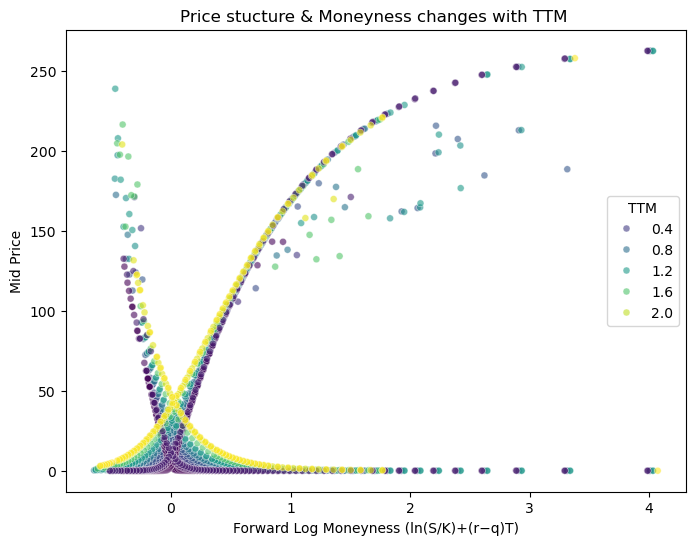

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="forward_log_moneyness",
    y="midPrice",
    hue="TTM",
    palette="viridis",
    alpha=0.6,
    s=25
)
plt.title("Price stucture & Moneyness changes with TTM ")
plt.xlabel("Forward Log Moneyness (ln(S/K)+(r−q)T)")
plt.ylabel("Mid Price")
plt.show()


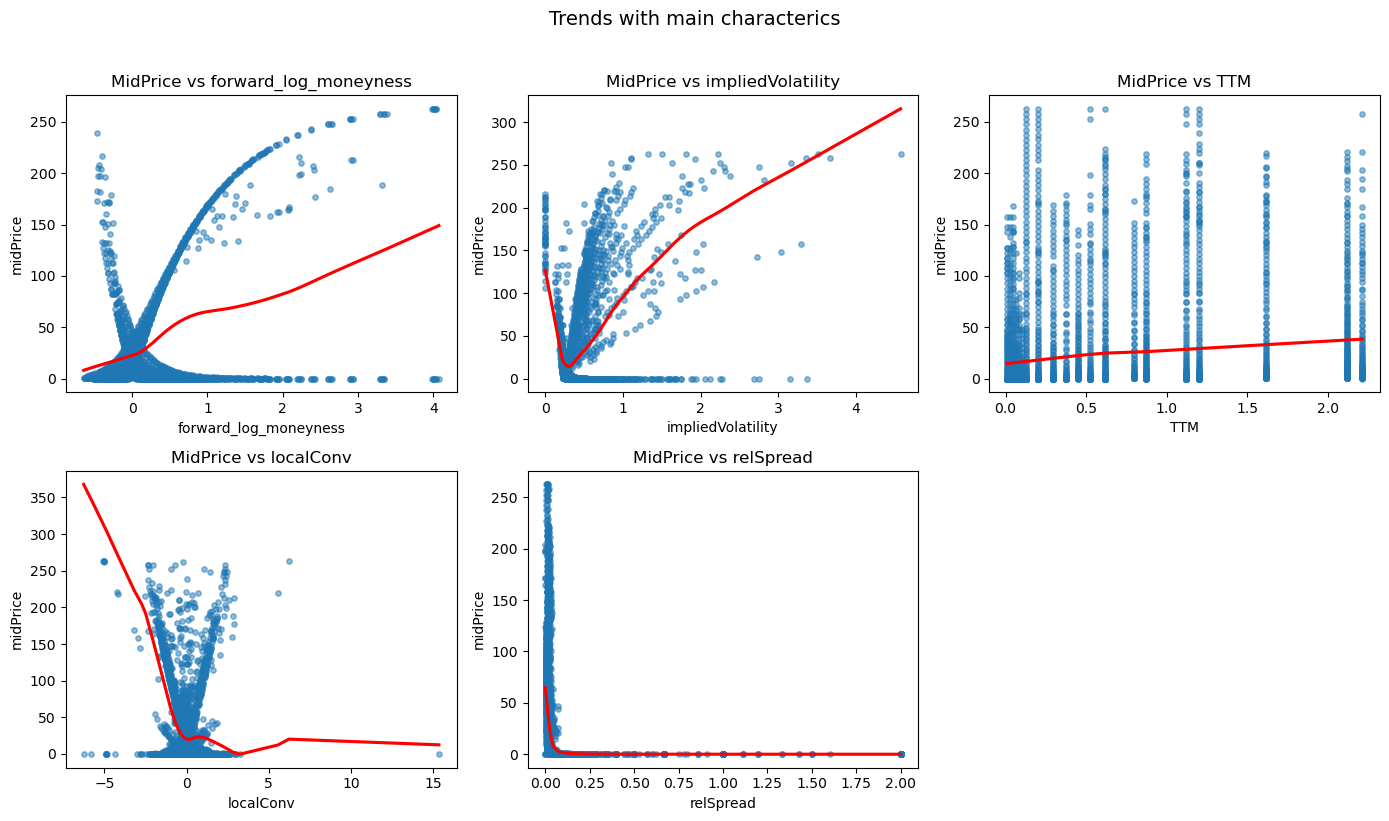

In [92]:
features = ["forward_log_moneyness", "impliedVolatility", "TTM", "localConv", "relSpread"]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.regplot(x=df[col], y=df["midPrice"],
                lowess=True,
                scatter_kws={'s':15, 'alpha':0.5},
                line_kws={'color':'red'}, ax=axes[i])
    axes[i].set_title(f"MidPrice vs {col}")
axes[-1].axis("off")
plt.suptitle("Trends with main characterics", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


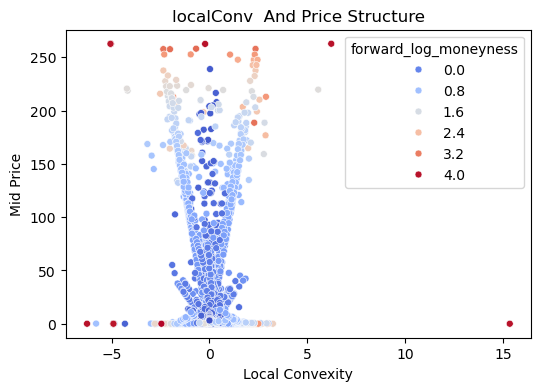

In [97]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="localConv", y="midPrice",
                hue="forward_log_moneyness", palette="coolwarm", s=25)
plt.title("localConv  And Price Structure")
plt.xlabel("Local Convexity")
plt.ylabel("Mid Price")
plt.show()


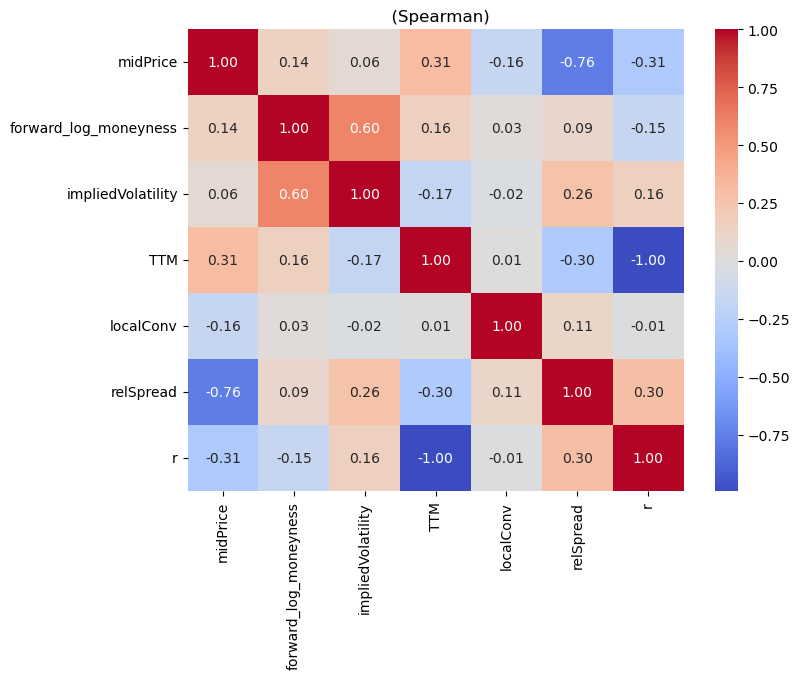

In [99]:
corr_cols = ["midPrice", "forward_log_moneyness", "impliedVolatility",
             "TTM", "localConv", "relSpread", "r"]
corr = df[corr_cols].corr(method="spearman")

import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("  (Spearman)")
plt.show()


**Interest Rate Interpolation**

In [ ]:
# Needs to figure out if we're using a interpolation structure to match each of them, also considering zero bond rates for the interpolation
def interest_rate(row):
    # Need to change this to interpolation calculation
    return (0.04)

In [ ]:
df["r"] = .04
df

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,TTM,...,spot_price,optionType,r,forward_log_moneyness,midPrice,relSpread,localConv,localConv_norm,has_mid,conv_ok
0,100.0,0.02,0.00,0.01,3.0,246,1.281254,REGULAR,USD,0.046575,...,267.744995,1,0.04,0.987197,0.005,2.000000,6.388121e-20,1.597030e-18,1,1
1,105.0,0.01,0.00,0.01,3.0,284,1.218754,REGULAR,USD,0.046575,...,267.744995,1,0.04,0.938406,0.005,2.000000,1.478211e-19,3.695527e-18,1,1
2,110.0,0.01,0.00,0.01,2.0,385,1.156254,REGULAR,USD,0.046575,...,267.744995,1,0.04,0.891886,0.005,2.000000,2.804516e-19,7.011289e-18,1,1
3,115.0,0.01,0.00,0.01,4.0,738,1.125004,REGULAR,USD,0.046575,...,267.744995,1,0.04,0.847435,0.005,2.000000,3.860577e-19,9.651442e-18,1,1
4,120.0,0.01,0.00,0.01,3.0,1073,1.062505,REGULAR,USD,0.046575,...,267.744995,1,0.04,0.804875,0.005,2.000000,2.565994e-19,6.414985e-18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,490.0,4.90,4.45,4.70,1.0,25,0.277290,REGULAR,USD,2.213699,...,267.744995,0,0.04,-0.511328,4.575,0.054645,6.438261e-04,6.438261e-02,1,1
2196,500.0,4.10,4.00,4.20,2.0,277,0.276588,REGULAR,USD,2.213699,...,267.744995,0,0.04,-0.531531,4.100,0.048780,6.035518e-04,6.035518e-02,1,1
2197,510.0,3.90,3.60,3.80,30.0,30,0.276649,REGULAR,USD,2.213699,...,267.744995,0,0.04,-0.551334,3.700,0.054054,5.178571e-04,5.178571e-02,1,1
2198,520.0,3.34,3.25,3.45,6.0,4,0.276893,REGULAR,USD,2.213699,...,267.744995,0,0.04,-0.570752,3.350,0.059701,5.428571e-04,5.428571e-02,1,1


**Implied Volatility**

**Forward log-Moneyness**

We decided to use forward log-moneyness because its adjusted for r and q which are crucial in pricing the EEP

In [ ]:

def forward_log_moneyness(S, r, q, T, K):
    forward_price = S * np.exp((r - q)*T)
    
    return np.log(K/forward_price)

In [ ]:
df["forward_log_moneyness"] = forward_log_moneyness(
    S=df["spot_price"].to_numpy(),
    r=df["r"].to_numpy(),
    q=df["dividendYield"].to_numpy(),
    T=df["TTM"].to_numpy(),
    K=df["strike"].to_numpy(),
)

df

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,contractSize,currency,TTM,...,spot_price,optionType,r,forward_log_moneyness,midPrice,relSpread,localConv,localConv_norm,has_mid,conv_ok
0,100.0,0.02,0.00,0.01,3.0,246,1.281254,REGULAR,USD,0.046575,...,267.744995,1,0.04,-0.986551,0.005,2.000000,6.388121e-20,1.597030e-18,1,1
1,105.0,0.01,0.00,0.01,3.0,284,1.218754,REGULAR,USD,0.046575,...,267.744995,1,0.04,-0.937761,0.005,2.000000,1.478211e-19,3.695527e-18,1,1
2,110.0,0.01,0.00,0.01,2.0,385,1.156254,REGULAR,USD,0.046575,...,267.744995,1,0.04,-0.891241,0.005,2.000000,2.804516e-19,7.011289e-18,1,1
3,115.0,0.01,0.00,0.01,4.0,738,1.125004,REGULAR,USD,0.046575,...,267.744995,1,0.04,-0.846789,0.005,2.000000,3.860577e-19,9.651442e-18,1,1
4,120.0,0.01,0.00,0.01,3.0,1073,1.062505,REGULAR,USD,0.046575,...,267.744995,1,0.04,-0.804229,0.005,2.000000,2.565994e-19,6.414985e-18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,490.0,4.90,4.45,4.70,1.0,25,0.277290,REGULAR,USD,2.213699,...,267.744995,0,0.04,0.524234,4.575,0.054645,6.438261e-04,6.438261e-02,1,1
2196,500.0,4.10,4.00,4.20,2.0,277,0.276588,REGULAR,USD,2.213699,...,267.744995,0,0.04,0.544437,4.100,0.048780,6.035518e-04,6.035518e-02,1,1
2197,510.0,3.90,3.60,3.80,30.0,30,0.276649,REGULAR,USD,2.213699,...,267.744995,0,0.04,0.564240,3.700,0.054054,5.178571e-04,5.178571e-02,1,1
2198,520.0,3.34,3.25,3.45,6.0,4,0.276893,REGULAR,USD,2.213699,...,267.744995,0,0.04,0.583658,3.350,0.059701,5.428571e-04,5.428571e-02,1,1


**European Option Equivalent Price**

**American Option Price**

In [ ]:
df.columns

Index(['strike', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest',
       'impliedVolatility', 'contractSize', 'currency', 'TTM', 'dividendYield',
       'ticker', 'spot_price', 'optionType', 'r', 'forward_log_moneyness',
       'midPrice', 'relSpread', 'localConv', 'localConv_norm', 'has_mid',
       'conv_ok'],
      dtype='object')